In [25]:
import activations
from torchvision.models import vgg19
import torch
import image_utils
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.functional import total_variation
from tqdm import tqdm

def prepare_content_style_random(content_path, style_path):
    h, w = 225, 225
    def prepare_image(path):
        image = image_utils.load_image_from(path)
        image = image_utils.resize_to_image(np.zeros((3, h, w)), image)
        image = process(image)
        return image_utils.prepare_input_image(image, requires_grad=False)
    content = prepare_image(content_path)
    style = prepare_image(style_path)
    random_image = image_utils.create_random_image(h, w)
    random_image = process(random_image)
    random_image = image_utils.prepare_input_image(random_image, requires_grad=True)
    return content, style, random_image

def show_image(image):
    img = image.detach().numpy().squeeze()
    img = deprocess(img)
    img = image_utils.channel_last(img)
    plt.imshow(img)

RGB_MEAN = np.expand_dims(np.array([0.485, 0.456, 0.406]), axis=(-2, -1))
RGB_STD = np.expand_dims(np.array([0.229, 0.224, 0.225]), axis=(-2, -1))

process = lambda img: (img - RGB_MEAN) / RGB_STD
deprocess = lambda img: (img * RGB_STD) + RGB_MEAN

def make_style_filters():
    filters = [activations.TypeActivationFilter(["Conv2d"]), activations.IndexActivationFilter([0, 2, 4, 8, 12])]
    return {"style": filters}

def make_content_filters():
    filters = [activations.TypeActivationFilter(["Conv2d"]), activations.IndexActivationFilter([3])]
    return {"content": filters}

def gram_matrix(feature_maps):
    a, b, c, d = feature_maps.size()  
    features = feature_maps.view(a * b, c * d) 
    G = torch.mm(features, features.t()) 
    return G.div(a * b * c * d)

activation_filters = make_style_filters() | make_content_filters()

In [26]:
m = activations.ModelWithActivations(vgg19(pretrained=True), activation_filters, torch.rand(1, 3, 224, 224))

In [51]:
content_image, style_image, random_image = prepare_content_style_random("zosia.jpg", "style_tutorial.png")

In [55]:
def maps_to_gram(list_of_feats):
    grams = [gram_matrix(feature_maps) for feature_maps in list_of_feats]
    return grams

def get_loss(ref_content, ref_style, image_content, image_style, content_weight=1, style_weight=100000):
    l_content = torch.nn.functional.mse_loss(ref_content, image_content)
    l_style = [torch.nn.functional.mse_loss(ref_style[i], image_style[i]) for i in range(len(ref_style))]
    l_style = torch.mean(torch.stack(l_style))
    print(l_content, l_style)
    loss = content_weight * l_content + style_weight * l_style
    return loss


def optimize_image(content_image, style_image, input_image, model, lr=0.1, n_iter=600, tv_coeff=10):
    image = np.copy(input_image.detach().numpy().squeeze())
    input_image = image_utils.prepare_input_image(image, requires_grad=True)
    model(content_image)
    ref_content = model.activations_values["content"][0]
    model(style_image)
    ref_style = maps_to_gram(model.activations_values["style"])
    optimizer = torch.optim.Adam([input_image], lr=lr)
    processed_images = []
    size = input_image.shape[-2] * input_image.shape[-1]
    
    for _ in tqdm(range(n_iter)):
        optimizer.zero_grad()
        model(input_image)
        image_content = model.activations_values["content"][0]
        image_style = maps_to_gram(model.activations_values["style"])
        tv = tv_coeff * total_variation(input_image) / size
        loss = get_loss(ref_content, ref_style, image_content, image_style) + tv
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            input_image.clamp_(0, 1)
        processed_images.append(np.copy(input_image.detach().numpy().squeeze()))
    return processed_images

In [56]:
processed_images = optimize_image(content_image, style_image, random_image, m)

  0%|              | 2/600 [00:00<00:42, 14.05it/s]

tensor(25.9432, grad_fn=<MseLossBackward0>) tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(9.4152, grad_fn=<MseLossBackward0>) tensor(9.4746e-05, grad_fn=<MeanBackward0>)
tensor(8.7167, grad_fn=<MseLossBackward0>) tensor(4.3256e-05, grad_fn=<MeanBackward0>)


  1%|▏             | 6/600 [00:00<00:42, 13.99it/s]

tensor(8.4027, grad_fn=<MseLossBackward0>) tensor(2.9336e-05, grad_fn=<MeanBackward0>)
tensor(8.2844, grad_fn=<MseLossBackward0>) tensor(2.4902e-05, grad_fn=<MeanBackward0>)
tensor(8.2621, grad_fn=<MseLossBackward0>) tensor(2.3927e-05, grad_fn=<MeanBackward0>)


  1%|▏             | 8/600 [00:00<00:42, 13.95it/s]

tensor(8.2806, grad_fn=<MseLossBackward0>) tensor(2.4354e-05, grad_fn=<MeanBackward0>)
tensor(8.3085, grad_fn=<MseLossBackward0>) tensor(2.5170e-05, grad_fn=<MeanBackward0>)
tensor(8.3288, grad_fn=<MseLossBackward0>) tensor(2.5735e-05, grad_fn=<MeanBackward0>)


  2%|▎            | 12/600 [00:00<00:42, 13.92it/s]

tensor(8.3336, grad_fn=<MseLossBackward0>) tensor(2.5658e-05, grad_fn=<MeanBackward0>)
tensor(8.3196, grad_fn=<MseLossBackward0>) tensor(2.5035e-05, grad_fn=<MeanBackward0>)
tensor(8.2875, grad_fn=<MseLossBackward0>) tensor(2.4056e-05, grad_fn=<MeanBackward0>)


  2%|▎            | 14/600 [00:01<00:42, 13.91it/s]

tensor(8.2384, grad_fn=<MseLossBackward0>) tensor(2.2950e-05, grad_fn=<MeanBackward0>)
tensor(8.1731, grad_fn=<MseLossBackward0>) tensor(2.1841e-05, grad_fn=<MeanBackward0>)
tensor(8.0935, grad_fn=<MseLossBackward0>) tensor(2.0766e-05, grad_fn=<MeanBackward0>)


  3%|▍            | 18/600 [00:01<00:41, 13.89it/s]

tensor(8.0014, grad_fn=<MseLossBackward0>) tensor(1.9722e-05, grad_fn=<MeanBackward0>)
tensor(7.8999, grad_fn=<MseLossBackward0>) tensor(1.8744e-05, grad_fn=<MeanBackward0>)
tensor(7.7907, grad_fn=<MseLossBackward0>) tensor(1.7854e-05, grad_fn=<MeanBackward0>)


  3%|▍            | 20/600 [00:01<00:41, 13.89it/s]

tensor(7.6755, grad_fn=<MseLossBackward0>) tensor(1.7038e-05, grad_fn=<MeanBackward0>)
tensor(7.5560, grad_fn=<MseLossBackward0>) tensor(1.6293e-05, grad_fn=<MeanBackward0>)
tensor(7.4339, grad_fn=<MseLossBackward0>) tensor(1.5610e-05, grad_fn=<MeanBackward0>)


  4%|▌            | 24/600 [00:01<00:42, 13.47it/s]

tensor(7.3106, grad_fn=<MseLossBackward0>) tensor(1.4992e-05, grad_fn=<MeanBackward0>)
tensor(7.1873, grad_fn=<MseLossBackward0>) tensor(1.4433e-05, grad_fn=<MeanBackward0>)
tensor(7.0656, grad_fn=<MseLossBackward0>) tensor(1.3925e-05, grad_fn=<MeanBackward0>)


  4%|▌            | 26/600 [00:01<00:42, 13.57it/s]

tensor(6.9456, grad_fn=<MseLossBackward0>) tensor(1.3464e-05, grad_fn=<MeanBackward0>)
tensor(6.8266, grad_fn=<MseLossBackward0>) tensor(1.3046e-05, grad_fn=<MeanBackward0>)
tensor(6.7100, grad_fn=<MseLossBackward0>) tensor(1.2662e-05, grad_fn=<MeanBackward0>)


  5%|▋            | 30/600 [00:02<00:41, 13.71it/s]

tensor(6.5948, grad_fn=<MseLossBackward0>) tensor(1.2315e-05, grad_fn=<MeanBackward0>)
tensor(6.4808, grad_fn=<MseLossBackward0>) tensor(1.1999e-05, grad_fn=<MeanBackward0>)
tensor(6.3681, grad_fn=<MseLossBackward0>) tensor(1.1705e-05, grad_fn=<MeanBackward0>)


  5%|▋            | 32/600 [00:02<00:41, 13.73it/s]

tensor(6.2574, grad_fn=<MseLossBackward0>) tensor(1.1429e-05, grad_fn=<MeanBackward0>)
tensor(6.1482, grad_fn=<MseLossBackward0>) tensor(1.1170e-05, grad_fn=<MeanBackward0>)
tensor(6.0403, grad_fn=<MseLossBackward0>) tensor(1.0921e-05, grad_fn=<MeanBackward0>)


  6%|▊            | 36/600 [00:02<00:40, 13.76it/s]

tensor(5.9353, grad_fn=<MseLossBackward0>) tensor(1.0691e-05, grad_fn=<MeanBackward0>)
tensor(5.8343, grad_fn=<MseLossBackward0>) tensor(1.0484e-05, grad_fn=<MeanBackward0>)
tensor(5.7369, grad_fn=<MseLossBackward0>) tensor(1.0299e-05, grad_fn=<MeanBackward0>)


  6%|▊            | 38/600 [00:02<00:40, 13.77it/s]

tensor(5.6430, grad_fn=<MseLossBackward0>) tensor(1.0133e-05, grad_fn=<MeanBackward0>)
tensor(5.5523, grad_fn=<MseLossBackward0>) tensor(9.9833e-06, grad_fn=<MeanBackward0>)
tensor(5.4642, grad_fn=<MseLossBackward0>) tensor(9.8449e-06, grad_fn=<MeanBackward0>)


  7%|▉            | 42/600 [00:03<00:40, 13.79it/s]

tensor(5.3788, grad_fn=<MseLossBackward0>) tensor(9.7228e-06, grad_fn=<MeanBackward0>)
tensor(5.2967, grad_fn=<MseLossBackward0>) tensor(9.6160e-06, grad_fn=<MeanBackward0>)
tensor(5.2180, grad_fn=<MseLossBackward0>) tensor(9.5178e-06, grad_fn=<MeanBackward0>)


  7%|▉            | 44/600 [00:03<00:40, 13.79it/s]

tensor(5.1427, grad_fn=<MseLossBackward0>) tensor(9.4275e-06, grad_fn=<MeanBackward0>)
tensor(5.0717, grad_fn=<MseLossBackward0>) tensor(9.3471e-06, grad_fn=<MeanBackward0>)
tensor(5.0036, grad_fn=<MseLossBackward0>) tensor(9.2897e-06, grad_fn=<MeanBackward0>)


  8%|█            | 48/600 [00:03<00:40, 13.80it/s]

tensor(4.9388, grad_fn=<MseLossBackward0>) tensor(9.2442e-06, grad_fn=<MeanBackward0>)
tensor(4.8774, grad_fn=<MseLossBackward0>) tensor(9.2039e-06, grad_fn=<MeanBackward0>)
tensor(4.8194, grad_fn=<MseLossBackward0>) tensor(9.1704e-06, grad_fn=<MeanBackward0>)


  8%|█            | 50/600 [00:03<00:39, 13.79it/s]

tensor(4.7635, grad_fn=<MseLossBackward0>) tensor(9.1466e-06, grad_fn=<MeanBackward0>)
tensor(4.7099, grad_fn=<MseLossBackward0>) tensor(9.1354e-06, grad_fn=<MeanBackward0>)
tensor(4.6603, grad_fn=<MseLossBackward0>) tensor(9.1321e-06, grad_fn=<MeanBackward0>)


  9%|█▏           | 54/600 [00:03<00:39, 13.79it/s]

tensor(4.6139, grad_fn=<MseLossBackward0>) tensor(9.1248e-06, grad_fn=<MeanBackward0>)
tensor(4.5699, grad_fn=<MseLossBackward0>) tensor(9.1145e-06, grad_fn=<MeanBackward0>)
tensor(4.5291, grad_fn=<MseLossBackward0>) tensor(9.1153e-06, grad_fn=<MeanBackward0>)


  9%|█▏           | 56/600 [00:04<00:39, 13.79it/s]

tensor(4.4906, grad_fn=<MseLossBackward0>) tensor(9.1281e-06, grad_fn=<MeanBackward0>)
tensor(4.4545, grad_fn=<MseLossBackward0>) tensor(9.1494e-06, grad_fn=<MeanBackward0>)
tensor(4.4202, grad_fn=<MseLossBackward0>) tensor(9.1773e-06, grad_fn=<MeanBackward0>)


 10%|█▎           | 60/600 [00:04<00:39, 13.80it/s]

tensor(4.3874, grad_fn=<MseLossBackward0>) tensor(9.2035e-06, grad_fn=<MeanBackward0>)
tensor(4.3575, grad_fn=<MseLossBackward0>) tensor(9.2234e-06, grad_fn=<MeanBackward0>)
tensor(4.3296, grad_fn=<MseLossBackward0>) tensor(9.2328e-06, grad_fn=<MeanBackward0>)


 10%|█▎           | 62/600 [00:04<00:38, 13.80it/s]

tensor(4.3036, grad_fn=<MseLossBackward0>) tensor(9.2321e-06, grad_fn=<MeanBackward0>)
tensor(4.2793, grad_fn=<MseLossBackward0>) tensor(9.2252e-06, grad_fn=<MeanBackward0>)
tensor(4.2560, grad_fn=<MseLossBackward0>) tensor(9.2242e-06, grad_fn=<MeanBackward0>)


 11%|█▍           | 66/600 [00:04<00:38, 13.82it/s]

tensor(4.2336, grad_fn=<MseLossBackward0>) tensor(9.2297e-06, grad_fn=<MeanBackward0>)
tensor(4.2126, grad_fn=<MseLossBackward0>) tensor(9.2366e-06, grad_fn=<MeanBackward0>)
tensor(4.1931, grad_fn=<MseLossBackward0>) tensor(9.2403e-06, grad_fn=<MeanBackward0>)


 11%|█▍           | 68/600 [00:04<00:38, 13.80it/s]

tensor(4.1755, grad_fn=<MseLossBackward0>) tensor(9.2366e-06, grad_fn=<MeanBackward0>)
tensor(4.1590, grad_fn=<MseLossBackward0>) tensor(9.2294e-06, grad_fn=<MeanBackward0>)
tensor(4.1427, grad_fn=<MseLossBackward0>) tensor(9.2246e-06, grad_fn=<MeanBackward0>)


 12%|█▌           | 72/600 [00:05<00:38, 13.81it/s]

tensor(4.1269, grad_fn=<MseLossBackward0>) tensor(9.2221e-06, grad_fn=<MeanBackward0>)
tensor(4.1118, grad_fn=<MseLossBackward0>) tensor(9.2165e-06, grad_fn=<MeanBackward0>)
tensor(4.0973, grad_fn=<MseLossBackward0>) tensor(9.2078e-06, grad_fn=<MeanBackward0>)


 12%|█▌           | 74/600 [00:05<00:38, 13.80it/s]

tensor(4.0840, grad_fn=<MseLossBackward0>) tensor(9.1964e-06, grad_fn=<MeanBackward0>)
tensor(4.0714, grad_fn=<MseLossBackward0>) tensor(9.1855e-06, grad_fn=<MeanBackward0>)
tensor(4.0597, grad_fn=<MseLossBackward0>) tensor(9.1736e-06, grad_fn=<MeanBackward0>)


 13%|█▋           | 78/600 [00:05<00:37, 13.81it/s]

tensor(4.0483, grad_fn=<MseLossBackward0>) tensor(9.1630e-06, grad_fn=<MeanBackward0>)
tensor(4.0376, grad_fn=<MseLossBackward0>) tensor(9.1496e-06, grad_fn=<MeanBackward0>)
tensor(4.0278, grad_fn=<MseLossBackward0>) tensor(9.1309e-06, grad_fn=<MeanBackward0>)


 13%|█▋           | 80/600 [00:05<00:37, 13.79it/s]

tensor(4.0187, grad_fn=<MseLossBackward0>) tensor(9.1048e-06, grad_fn=<MeanBackward0>)
tensor(4.0093, grad_fn=<MseLossBackward0>) tensor(9.0830e-06, grad_fn=<MeanBackward0>)
tensor(3.9996, grad_fn=<MseLossBackward0>) tensor(9.0675e-06, grad_fn=<MeanBackward0>)


 14%|█▊           | 84/600 [00:06<00:37, 13.80it/s]

tensor(3.9902, grad_fn=<MseLossBackward0>) tensor(9.0493e-06, grad_fn=<MeanBackward0>)
tensor(3.9811, grad_fn=<MseLossBackward0>) tensor(9.0326e-06, grad_fn=<MeanBackward0>)
tensor(3.9725, grad_fn=<MseLossBackward0>) tensor(9.0157e-06, grad_fn=<MeanBackward0>)


 14%|█▊           | 86/600 [00:06<00:37, 13.79it/s]

tensor(3.9643, grad_fn=<MseLossBackward0>) tensor(9.0022e-06, grad_fn=<MeanBackward0>)
tensor(3.9564, grad_fn=<MseLossBackward0>) tensor(8.9921e-06, grad_fn=<MeanBackward0>)
tensor(3.9488, grad_fn=<MseLossBackward0>) tensor(8.9855e-06, grad_fn=<MeanBackward0>)


 15%|█▉           | 90/600 [00:06<00:36, 13.80it/s]

tensor(3.9415, grad_fn=<MseLossBackward0>) tensor(8.9714e-06, grad_fn=<MeanBackward0>)
tensor(3.9344, grad_fn=<MseLossBackward0>) tensor(8.9518e-06, grad_fn=<MeanBackward0>)
tensor(3.9278, grad_fn=<MseLossBackward0>) tensor(8.9304e-06, grad_fn=<MeanBackward0>)


 15%|█▉           | 92/600 [00:06<00:36, 13.79it/s]

tensor(3.9218, grad_fn=<MseLossBackward0>) tensor(8.9134e-06, grad_fn=<MeanBackward0>)
tensor(3.9162, grad_fn=<MseLossBackward0>) tensor(8.9008e-06, grad_fn=<MeanBackward0>)
tensor(3.9104, grad_fn=<MseLossBackward0>) tensor(8.8851e-06, grad_fn=<MeanBackward0>)


 16%|██           | 96/600 [00:06<00:36, 13.80it/s]

tensor(3.9049, grad_fn=<MseLossBackward0>) tensor(8.8703e-06, grad_fn=<MeanBackward0>)
tensor(3.8998, grad_fn=<MseLossBackward0>) tensor(8.8552e-06, grad_fn=<MeanBackward0>)
tensor(3.8949, grad_fn=<MseLossBackward0>) tensor(8.8410e-06, grad_fn=<MeanBackward0>)


 16%|██           | 98/600 [00:07<00:36, 13.80it/s]

tensor(3.8900, grad_fn=<MseLossBackward0>) tensor(8.8296e-06, grad_fn=<MeanBackward0>)
tensor(3.8850, grad_fn=<MseLossBackward0>) tensor(8.8176e-06, grad_fn=<MeanBackward0>)
tensor(3.8799, grad_fn=<MseLossBackward0>) tensor(8.8088e-06, grad_fn=<MeanBackward0>)


 17%|██          | 102/600 [00:07<00:36, 13.79it/s]

tensor(3.8756, grad_fn=<MseLossBackward0>) tensor(8.7975e-06, grad_fn=<MeanBackward0>)
tensor(3.8718, grad_fn=<MseLossBackward0>) tensor(8.7863e-06, grad_fn=<MeanBackward0>)
tensor(3.8687, grad_fn=<MseLossBackward0>) tensor(8.7734e-06, grad_fn=<MeanBackward0>)


 17%|██          | 104/600 [00:07<00:35, 13.79it/s]

tensor(3.8650, grad_fn=<MseLossBackward0>) tensor(8.7600e-06, grad_fn=<MeanBackward0>)
tensor(3.8606, grad_fn=<MseLossBackward0>) tensor(8.7465e-06, grad_fn=<MeanBackward0>)
tensor(3.8562, grad_fn=<MseLossBackward0>) tensor(8.7303e-06, grad_fn=<MeanBackward0>)


 18%|██▏         | 108/600 [00:07<00:35, 13.80it/s]

tensor(3.8519, grad_fn=<MseLossBackward0>) tensor(8.7164e-06, grad_fn=<MeanBackward0>)
tensor(3.8485, grad_fn=<MseLossBackward0>) tensor(8.7027e-06, grad_fn=<MeanBackward0>)
tensor(3.8445, grad_fn=<MseLossBackward0>) tensor(8.6939e-06, grad_fn=<MeanBackward0>)


 18%|██▏         | 110/600 [00:07<00:35, 13.79it/s]

tensor(3.8412, grad_fn=<MseLossBackward0>) tensor(8.6843e-06, grad_fn=<MeanBackward0>)
tensor(3.8381, grad_fn=<MseLossBackward0>) tensor(8.6719e-06, grad_fn=<MeanBackward0>)
tensor(3.8353, grad_fn=<MseLossBackward0>) tensor(8.6583e-06, grad_fn=<MeanBackward0>)


 19%|██▎         | 114/600 [00:08<00:35, 13.81it/s]

tensor(3.8313, grad_fn=<MseLossBackward0>) tensor(8.6454e-06, grad_fn=<MeanBackward0>)
tensor(3.8276, grad_fn=<MseLossBackward0>) tensor(8.6365e-06, grad_fn=<MeanBackward0>)
tensor(3.8242, grad_fn=<MseLossBackward0>) tensor(8.6282e-06, grad_fn=<MeanBackward0>)


 19%|██▎         | 116/600 [00:08<00:35, 13.80it/s]

tensor(3.8214, grad_fn=<MseLossBackward0>) tensor(8.6189e-06, grad_fn=<MeanBackward0>)
tensor(3.8195, grad_fn=<MseLossBackward0>) tensor(8.6087e-06, grad_fn=<MeanBackward0>)
tensor(3.8170, grad_fn=<MseLossBackward0>) tensor(8.5992e-06, grad_fn=<MeanBackward0>)


 20%|██▍         | 120/600 [00:08<00:34, 13.81it/s]

tensor(3.8140, grad_fn=<MseLossBackward0>) tensor(8.5921e-06, grad_fn=<MeanBackward0>)
tensor(3.8110, grad_fn=<MseLossBackward0>) tensor(8.5841e-06, grad_fn=<MeanBackward0>)
tensor(3.8079, grad_fn=<MseLossBackward0>) tensor(8.5764e-06, grad_fn=<MeanBackward0>)


 20%|██▍         | 122/600 [00:08<00:34, 13.80it/s]

tensor(3.8052, grad_fn=<MseLossBackward0>) tensor(8.5682e-06, grad_fn=<MeanBackward0>)
tensor(3.8032, grad_fn=<MseLossBackward0>) tensor(8.5588e-06, grad_fn=<MeanBackward0>)
tensor(3.8013, grad_fn=<MseLossBackward0>) tensor(8.5526e-06, grad_fn=<MeanBackward0>)


 21%|██▌         | 126/600 [00:09<00:34, 13.81it/s]

tensor(3.7992, grad_fn=<MseLossBackward0>) tensor(8.5444e-06, grad_fn=<MeanBackward0>)
tensor(3.7971, grad_fn=<MseLossBackward0>) tensor(8.5375e-06, grad_fn=<MeanBackward0>)
tensor(3.7948, grad_fn=<MseLossBackward0>) tensor(8.5316e-06, grad_fn=<MeanBackward0>)


 21%|██▌         | 128/600 [00:09<00:35, 13.44it/s]

tensor(3.7927, grad_fn=<MseLossBackward0>) tensor(8.5266e-06, grad_fn=<MeanBackward0>)
tensor(3.7905, grad_fn=<MseLossBackward0>) tensor(8.5203e-06, grad_fn=<MeanBackward0>)
tensor(3.7883, grad_fn=<MseLossBackward0>) tensor(8.5079e-06, grad_fn=<MeanBackward0>)


 22%|██▋         | 132/600 [00:09<00:34, 13.63it/s]

tensor(3.7863, grad_fn=<MseLossBackward0>) tensor(8.4970e-06, grad_fn=<MeanBackward0>)
tensor(3.7842, grad_fn=<MseLossBackward0>) tensor(8.4928e-06, grad_fn=<MeanBackward0>)
tensor(3.7816, grad_fn=<MseLossBackward0>) tensor(8.4897e-06, grad_fn=<MeanBackward0>)


 22%|██▋         | 134/600 [00:09<00:34, 13.67it/s]

tensor(3.7793, grad_fn=<MseLossBackward0>) tensor(8.4863e-06, grad_fn=<MeanBackward0>)
tensor(3.7774, grad_fn=<MseLossBackward0>) tensor(8.4760e-06, grad_fn=<MeanBackward0>)
tensor(3.7749, grad_fn=<MseLossBackward0>) tensor(8.4688e-06, grad_fn=<MeanBackward0>)


 23%|██▊         | 138/600 [00:10<00:33, 13.73it/s]

tensor(3.7727, grad_fn=<MseLossBackward0>) tensor(8.4643e-06, grad_fn=<MeanBackward0>)
tensor(3.7710, grad_fn=<MseLossBackward0>) tensor(8.4594e-06, grad_fn=<MeanBackward0>)
tensor(3.7695, grad_fn=<MseLossBackward0>) tensor(8.4496e-06, grad_fn=<MeanBackward0>)


 23%|██▊         | 140/600 [00:10<00:33, 13.74it/s]

tensor(3.7675, grad_fn=<MseLossBackward0>) tensor(8.4413e-06, grad_fn=<MeanBackward0>)
tensor(3.7651, grad_fn=<MseLossBackward0>) tensor(8.4387e-06, grad_fn=<MeanBackward0>)
tensor(3.7631, grad_fn=<MseLossBackward0>) tensor(8.4296e-06, grad_fn=<MeanBackward0>)


 24%|██▉         | 144/600 [00:10<00:33, 13.79it/s]

tensor(3.7617, grad_fn=<MseLossBackward0>) tensor(8.4180e-06, grad_fn=<MeanBackward0>)
tensor(3.7599, grad_fn=<MseLossBackward0>) tensor(8.4149e-06, grad_fn=<MeanBackward0>)
tensor(3.7580, grad_fn=<MseLossBackward0>) tensor(8.4135e-06, grad_fn=<MeanBackward0>)


 24%|██▉         | 146/600 [00:10<00:32, 13.80it/s]

tensor(3.7565, grad_fn=<MseLossBackward0>) tensor(8.4060e-06, grad_fn=<MeanBackward0>)
tensor(3.7548, grad_fn=<MseLossBackward0>) tensor(8.3943e-06, grad_fn=<MeanBackward0>)
tensor(3.7524, grad_fn=<MseLossBackward0>) tensor(8.3850e-06, grad_fn=<MeanBackward0>)


 25%|███         | 150/600 [00:10<00:32, 13.80it/s]

tensor(3.7498, grad_fn=<MseLossBackward0>) tensor(8.3843e-06, grad_fn=<MeanBackward0>)
tensor(3.7471, grad_fn=<MseLossBackward0>) tensor(8.3835e-06, grad_fn=<MeanBackward0>)
tensor(3.7458, grad_fn=<MseLossBackward0>) tensor(8.3747e-06, grad_fn=<MeanBackward0>)


 25%|███         | 152/600 [00:11<00:32, 13.80it/s]

tensor(3.7448, grad_fn=<MseLossBackward0>) tensor(8.3673e-06, grad_fn=<MeanBackward0>)
tensor(3.7433, grad_fn=<MseLossBackward0>) tensor(8.3620e-06, grad_fn=<MeanBackward0>)
tensor(3.7413, grad_fn=<MseLossBackward0>) tensor(8.3563e-06, grad_fn=<MeanBackward0>)


 26%|███         | 156/600 [00:11<00:32, 13.81it/s]

tensor(3.7386, grad_fn=<MseLossBackward0>) tensor(8.3519e-06, grad_fn=<MeanBackward0>)
tensor(3.7366, grad_fn=<MseLossBackward0>) tensor(8.3488e-06, grad_fn=<MeanBackward0>)
tensor(3.7355, grad_fn=<MseLossBackward0>) tensor(8.3445e-06, grad_fn=<MeanBackward0>)


 26%|███▏        | 158/600 [00:11<00:32, 13.80it/s]

tensor(3.7347, grad_fn=<MseLossBackward0>) tensor(8.3375e-06, grad_fn=<MeanBackward0>)
tensor(3.7330, grad_fn=<MseLossBackward0>) tensor(8.3290e-06, grad_fn=<MeanBackward0>)
tensor(3.7309, grad_fn=<MseLossBackward0>) tensor(8.3252e-06, grad_fn=<MeanBackward0>)


 27%|███▏        | 162/600 [00:11<00:31, 13.81it/s]

tensor(3.7294, grad_fn=<MseLossBackward0>) tensor(8.3247e-06, grad_fn=<MeanBackward0>)
tensor(3.7276, grad_fn=<MseLossBackward0>) tensor(8.3187e-06, grad_fn=<MeanBackward0>)
tensor(3.7260, grad_fn=<MseLossBackward0>) tensor(8.3161e-06, grad_fn=<MeanBackward0>)


 27%|███▎        | 164/600 [00:11<00:31, 13.80it/s]

tensor(3.7246, grad_fn=<MseLossBackward0>) tensor(8.3122e-06, grad_fn=<MeanBackward0>)
tensor(3.7233, grad_fn=<MseLossBackward0>) tensor(8.3084e-06, grad_fn=<MeanBackward0>)
tensor(3.7222, grad_fn=<MseLossBackward0>) tensor(8.3045e-06, grad_fn=<MeanBackward0>)


 28%|███▎        | 168/600 [00:12<00:31, 13.80it/s]

tensor(3.7219, grad_fn=<MseLossBackward0>) tensor(8.2985e-06, grad_fn=<MeanBackward0>)
tensor(3.7211, grad_fn=<MseLossBackward0>) tensor(8.2964e-06, grad_fn=<MeanBackward0>)
tensor(3.7192, grad_fn=<MseLossBackward0>) tensor(8.2984e-06, grad_fn=<MeanBackward0>)


 28%|███▍        | 170/600 [00:12<00:31, 13.80it/s]

tensor(3.7180, grad_fn=<MseLossBackward0>) tensor(8.2888e-06, grad_fn=<MeanBackward0>)
tensor(3.7166, grad_fn=<MseLossBackward0>) tensor(8.2811e-06, grad_fn=<MeanBackward0>)
tensor(3.7151, grad_fn=<MseLossBackward0>) tensor(8.2774e-06, grad_fn=<MeanBackward0>)


 29%|███▍        | 174/600 [00:12<00:30, 13.80it/s]

tensor(3.7138, grad_fn=<MseLossBackward0>) tensor(8.2720e-06, grad_fn=<MeanBackward0>)
tensor(3.7127, grad_fn=<MseLossBackward0>) tensor(8.2644e-06, grad_fn=<MeanBackward0>)
tensor(3.7120, grad_fn=<MseLossBackward0>) tensor(8.2608e-06, grad_fn=<MeanBackward0>)


 29%|███▌        | 176/600 [00:12<00:30, 13.77it/s]

tensor(3.7110, grad_fn=<MseLossBackward0>) tensor(8.2606e-06, grad_fn=<MeanBackward0>)
tensor(3.7100, grad_fn=<MseLossBackward0>) tensor(8.2582e-06, grad_fn=<MeanBackward0>)
tensor(3.7091, grad_fn=<MseLossBackward0>) tensor(8.2500e-06, grad_fn=<MeanBackward0>)


 30%|███▌        | 180/600 [00:13<00:30, 13.78it/s]

tensor(3.7080, grad_fn=<MseLossBackward0>) tensor(8.2439e-06, grad_fn=<MeanBackward0>)
tensor(3.7062, grad_fn=<MseLossBackward0>) tensor(8.2403e-06, grad_fn=<MeanBackward0>)
tensor(3.7045, grad_fn=<MseLossBackward0>) tensor(8.2380e-06, grad_fn=<MeanBackward0>)


 30%|███▋        | 182/600 [00:13<00:30, 13.78it/s]

tensor(3.7038, grad_fn=<MseLossBackward0>) tensor(8.2330e-06, grad_fn=<MeanBackward0>)
tensor(3.7036, grad_fn=<MseLossBackward0>) tensor(8.2265e-06, grad_fn=<MeanBackward0>)
tensor(3.7024, grad_fn=<MseLossBackward0>) tensor(8.2243e-06, grad_fn=<MeanBackward0>)


 31%|███▋        | 186/600 [00:13<00:30, 13.79it/s]

tensor(3.7010, grad_fn=<MseLossBackward0>) tensor(8.2218e-06, grad_fn=<MeanBackward0>)
tensor(3.6998, grad_fn=<MseLossBackward0>) tensor(8.2181e-06, grad_fn=<MeanBackward0>)
tensor(3.6991, grad_fn=<MseLossBackward0>) tensor(8.2125e-06, grad_fn=<MeanBackward0>)


 31%|███▊        | 188/600 [00:13<00:29, 13.79it/s]

tensor(3.6980, grad_fn=<MseLossBackward0>) tensor(8.2055e-06, grad_fn=<MeanBackward0>)
tensor(3.6966, grad_fn=<MseLossBackward0>) tensor(8.2022e-06, grad_fn=<MeanBackward0>)
tensor(3.6954, grad_fn=<MseLossBackward0>) tensor(8.1984e-06, grad_fn=<MeanBackward0>)


 32%|███▊        | 192/600 [00:13<00:29, 13.78it/s]

tensor(3.6947, grad_fn=<MseLossBackward0>) tensor(8.1972e-06, grad_fn=<MeanBackward0>)
tensor(3.6941, grad_fn=<MseLossBackward0>) tensor(8.1968e-06, grad_fn=<MeanBackward0>)
tensor(3.6929, grad_fn=<MseLossBackward0>) tensor(8.1894e-06, grad_fn=<MeanBackward0>)


 32%|███▉        | 194/600 [00:14<00:29, 13.77it/s]

tensor(3.6923, grad_fn=<MseLossBackward0>) tensor(8.1776e-06, grad_fn=<MeanBackward0>)
tensor(3.6915, grad_fn=<MseLossBackward0>) tensor(8.1740e-06, grad_fn=<MeanBackward0>)
tensor(3.6902, grad_fn=<MseLossBackward0>) tensor(8.1735e-06, grad_fn=<MeanBackward0>)


 33%|███▉        | 198/600 [00:14<00:29, 13.79it/s]

tensor(3.6889, grad_fn=<MseLossBackward0>) tensor(8.1715e-06, grad_fn=<MeanBackward0>)
tensor(3.6879, grad_fn=<MseLossBackward0>) tensor(8.1678e-06, grad_fn=<MeanBackward0>)
tensor(3.6868, grad_fn=<MseLossBackward0>) tensor(8.1626e-06, grad_fn=<MeanBackward0>)


 33%|████        | 200/600 [00:14<00:29, 13.78it/s]

tensor(3.6860, grad_fn=<MseLossBackward0>) tensor(8.1591e-06, grad_fn=<MeanBackward0>)
tensor(3.6849, grad_fn=<MseLossBackward0>) tensor(8.1540e-06, grad_fn=<MeanBackward0>)
tensor(3.6841, grad_fn=<MseLossBackward0>) tensor(8.1493e-06, grad_fn=<MeanBackward0>)


 34%|████        | 204/600 [00:14<00:28, 13.79it/s]

tensor(3.6821, grad_fn=<MseLossBackward0>) tensor(8.1509e-06, grad_fn=<MeanBackward0>)
tensor(3.6809, grad_fn=<MseLossBackward0>) tensor(8.1529e-06, grad_fn=<MeanBackward0>)
tensor(3.6800, grad_fn=<MseLossBackward0>) tensor(8.1512e-06, grad_fn=<MeanBackward0>)


 34%|████        | 206/600 [00:14<00:28, 13.77it/s]

tensor(3.6800, grad_fn=<MseLossBackward0>) tensor(8.1375e-06, grad_fn=<MeanBackward0>)
tensor(3.6794, grad_fn=<MseLossBackward0>) tensor(8.1274e-06, grad_fn=<MeanBackward0>)
tensor(3.6781, grad_fn=<MseLossBackward0>) tensor(8.1271e-06, grad_fn=<MeanBackward0>)


 35%|████▏       | 210/600 [00:15<00:28, 13.80it/s]

tensor(3.6766, grad_fn=<MseLossBackward0>) tensor(8.1324e-06, grad_fn=<MeanBackward0>)
tensor(3.6758, grad_fn=<MseLossBackward0>) tensor(8.1321e-06, grad_fn=<MeanBackward0>)
tensor(3.6749, grad_fn=<MseLossBackward0>) tensor(8.1282e-06, grad_fn=<MeanBackward0>)


 35%|████▏       | 212/600 [00:15<00:28, 13.80it/s]

tensor(3.6739, grad_fn=<MseLossBackward0>) tensor(8.1233e-06, grad_fn=<MeanBackward0>)
tensor(3.6726, grad_fn=<MseLossBackward0>) tensor(8.1177e-06, grad_fn=<MeanBackward0>)
tensor(3.6717, grad_fn=<MseLossBackward0>) tensor(8.1143e-06, grad_fn=<MeanBackward0>)


 36%|████▎       | 216/600 [00:15<00:27, 13.80it/s]

tensor(3.6708, grad_fn=<MseLossBackward0>) tensor(8.1169e-06, grad_fn=<MeanBackward0>)
tensor(3.6702, grad_fn=<MseLossBackward0>) tensor(8.1123e-06, grad_fn=<MeanBackward0>)
tensor(3.6700, grad_fn=<MseLossBackward0>) tensor(8.1023e-06, grad_fn=<MeanBackward0>)


 36%|████▎       | 218/600 [00:15<00:27, 13.79it/s]

tensor(3.6695, grad_fn=<MseLossBackward0>) tensor(8.0941e-06, grad_fn=<MeanBackward0>)
tensor(3.6690, grad_fn=<MseLossBackward0>) tensor(8.0880e-06, grad_fn=<MeanBackward0>)
tensor(3.6680, grad_fn=<MseLossBackward0>) tensor(8.0878e-06, grad_fn=<MeanBackward0>)


 37%|████▍       | 222/600 [00:16<00:27, 13.81it/s]

tensor(3.6666, grad_fn=<MseLossBackward0>) tensor(8.0868e-06, grad_fn=<MeanBackward0>)
tensor(3.6661, grad_fn=<MseLossBackward0>) tensor(8.0835e-06, grad_fn=<MeanBackward0>)
tensor(3.6656, grad_fn=<MseLossBackward0>) tensor(8.0796e-06, grad_fn=<MeanBackward0>)


 37%|████▍       | 224/600 [00:16<00:27, 13.77it/s]

tensor(3.6647, grad_fn=<MseLossBackward0>) tensor(8.0792e-06, grad_fn=<MeanBackward0>)
tensor(3.6639, grad_fn=<MseLossBackward0>) tensor(8.0741e-06, grad_fn=<MeanBackward0>)
tensor(3.6639, grad_fn=<MseLossBackward0>) tensor(8.0681e-06, grad_fn=<MeanBackward0>)


 38%|████▌       | 228/600 [00:16<00:26, 13.80it/s]

tensor(3.6641, grad_fn=<MseLossBackward0>) tensor(8.0639e-06, grad_fn=<MeanBackward0>)
tensor(3.6632, grad_fn=<MseLossBackward0>) tensor(8.0609e-06, grad_fn=<MeanBackward0>)
tensor(3.6619, grad_fn=<MseLossBackward0>) tensor(8.0614e-06, grad_fn=<MeanBackward0>)


 38%|████▌       | 230/600 [00:16<00:26, 13.80it/s]

tensor(3.6610, grad_fn=<MseLossBackward0>) tensor(8.0639e-06, grad_fn=<MeanBackward0>)
tensor(3.6607, grad_fn=<MseLossBackward0>) tensor(8.0699e-06, grad_fn=<MeanBackward0>)
tensor(3.6610, grad_fn=<MseLossBackward0>) tensor(8.0660e-06, grad_fn=<MeanBackward0>)


 39%|████▋       | 234/600 [00:16<00:26, 13.80it/s]

tensor(3.6610, grad_fn=<MseLossBackward0>) tensor(8.0576e-06, grad_fn=<MeanBackward0>)
tensor(3.6601, grad_fn=<MseLossBackward0>) tensor(8.0537e-06, grad_fn=<MeanBackward0>)
tensor(3.6589, grad_fn=<MseLossBackward0>) tensor(8.0532e-06, grad_fn=<MeanBackward0>)


 39%|████▋       | 236/600 [00:17<00:26, 13.80it/s]

tensor(3.6577, grad_fn=<MseLossBackward0>) tensor(8.0537e-06, grad_fn=<MeanBackward0>)
tensor(3.6571, grad_fn=<MseLossBackward0>) tensor(8.0499e-06, grad_fn=<MeanBackward0>)
tensor(3.6571, grad_fn=<MseLossBackward0>) tensor(8.0397e-06, grad_fn=<MeanBackward0>)


 40%|████▊       | 240/600 [00:17<00:26, 13.81it/s]

tensor(3.6567, grad_fn=<MseLossBackward0>) tensor(8.0350e-06, grad_fn=<MeanBackward0>)
tensor(3.6563, grad_fn=<MseLossBackward0>) tensor(8.0338e-06, grad_fn=<MeanBackward0>)
tensor(3.6555, grad_fn=<MseLossBackward0>) tensor(8.0294e-06, grad_fn=<MeanBackward0>)


 40%|████▊       | 242/600 [00:17<00:25, 13.83it/s]

tensor(3.6545, grad_fn=<MseLossBackward0>) tensor(8.0269e-06, grad_fn=<MeanBackward0>)
tensor(3.6539, grad_fn=<MseLossBackward0>) tensor(8.0249e-06, grad_fn=<MeanBackward0>)
tensor(3.6527, grad_fn=<MseLossBackward0>) tensor(8.0232e-06, grad_fn=<MeanBackward0>)


 41%|████▉       | 246/600 [00:17<00:25, 13.83it/s]

tensor(3.6520, grad_fn=<MseLossBackward0>) tensor(8.0213e-06, grad_fn=<MeanBackward0>)
tensor(3.6515, grad_fn=<MseLossBackward0>) tensor(8.0202e-06, grad_fn=<MeanBackward0>)
tensor(3.6510, grad_fn=<MseLossBackward0>) tensor(8.0191e-06, grad_fn=<MeanBackward0>)


 41%|████▉       | 248/600 [00:17<00:25, 13.82it/s]

tensor(3.6504, grad_fn=<MseLossBackward0>) tensor(8.0089e-06, grad_fn=<MeanBackward0>)
tensor(3.6496, grad_fn=<MseLossBackward0>) tensor(7.9996e-06, grad_fn=<MeanBackward0>)
tensor(3.6487, grad_fn=<MseLossBackward0>) tensor(7.9999e-06, grad_fn=<MeanBackward0>)


 42%|█████       | 252/600 [00:18<00:25, 13.82it/s]

tensor(3.6476, grad_fn=<MseLossBackward0>) tensor(8.0040e-06, grad_fn=<MeanBackward0>)
tensor(3.6472, grad_fn=<MseLossBackward0>) tensor(8.0019e-06, grad_fn=<MeanBackward0>)
tensor(3.6474, grad_fn=<MseLossBackward0>) tensor(7.9962e-06, grad_fn=<MeanBackward0>)


 42%|█████       | 254/600 [00:18<00:25, 13.82it/s]

tensor(3.6470, grad_fn=<MseLossBackward0>) tensor(7.9990e-06, grad_fn=<MeanBackward0>)
tensor(3.6460, grad_fn=<MseLossBackward0>) tensor(8.0044e-06, grad_fn=<MeanBackward0>)
tensor(3.6455, grad_fn=<MseLossBackward0>) tensor(8.0014e-06, grad_fn=<MeanBackward0>)


 43%|█████▏      | 258/600 [00:18<00:24, 13.82it/s]

tensor(3.6454, grad_fn=<MseLossBackward0>) tensor(7.9952e-06, grad_fn=<MeanBackward0>)
tensor(3.6454, grad_fn=<MseLossBackward0>) tensor(7.9935e-06, grad_fn=<MeanBackward0>)
tensor(3.6450, grad_fn=<MseLossBackward0>) tensor(7.9883e-06, grad_fn=<MeanBackward0>)


 43%|█████▏      | 260/600 [00:18<00:24, 13.79it/s]

tensor(3.6444, grad_fn=<MseLossBackward0>) tensor(7.9890e-06, grad_fn=<MeanBackward0>)
tensor(3.6439, grad_fn=<MseLossBackward0>) tensor(7.9895e-06, grad_fn=<MeanBackward0>)
tensor(3.6434, grad_fn=<MseLossBackward0>) tensor(7.9844e-06, grad_fn=<MeanBackward0>)


 44%|█████▎      | 264/600 [00:19<00:25, 13.03it/s]

tensor(3.6429, grad_fn=<MseLossBackward0>) tensor(7.9795e-06, grad_fn=<MeanBackward0>)
tensor(3.6416, grad_fn=<MseLossBackward0>) tensor(7.9808e-06, grad_fn=<MeanBackward0>)
tensor(3.6410, grad_fn=<MseLossBackward0>) tensor(7.9807e-06, grad_fn=<MeanBackward0>)


 44%|█████▎      | 266/600 [00:19<00:25, 13.25it/s]

tensor(3.6411, grad_fn=<MseLossBackward0>) tensor(7.9736e-06, grad_fn=<MeanBackward0>)
tensor(3.6407, grad_fn=<MseLossBackward0>) tensor(7.9673e-06, grad_fn=<MeanBackward0>)
tensor(3.6398, grad_fn=<MseLossBackward0>) tensor(7.9648e-06, grad_fn=<MeanBackward0>)


 45%|█████▍      | 270/600 [00:19<00:24, 13.53it/s]

tensor(3.6393, grad_fn=<MseLossBackward0>) tensor(7.9618e-06, grad_fn=<MeanBackward0>)
tensor(3.6390, grad_fn=<MseLossBackward0>) tensor(7.9541e-06, grad_fn=<MeanBackward0>)
tensor(3.6390, grad_fn=<MseLossBackward0>) tensor(7.9510e-06, grad_fn=<MeanBackward0>)


 45%|█████▍      | 272/600 [00:19<00:24, 13.61it/s]

tensor(3.6389, grad_fn=<MseLossBackward0>) tensor(7.9570e-06, grad_fn=<MeanBackward0>)
tensor(3.6382, grad_fn=<MseLossBackward0>) tensor(7.9627e-06, grad_fn=<MeanBackward0>)
tensor(3.6376, grad_fn=<MseLossBackward0>) tensor(7.9558e-06, grad_fn=<MeanBackward0>)


 46%|█████▌      | 276/600 [00:20<00:23, 13.72it/s]

tensor(3.6371, grad_fn=<MseLossBackward0>) tensor(7.9521e-06, grad_fn=<MeanBackward0>)
tensor(3.6363, grad_fn=<MseLossBackward0>) tensor(7.9496e-06, grad_fn=<MeanBackward0>)
tensor(3.6367, grad_fn=<MseLossBackward0>) tensor(7.9388e-06, grad_fn=<MeanBackward0>)


 46%|█████▌      | 278/600 [00:20<00:23, 13.74it/s]

tensor(3.6364, grad_fn=<MseLossBackward0>) tensor(7.9283e-06, grad_fn=<MeanBackward0>)
tensor(3.6356, grad_fn=<MseLossBackward0>) tensor(7.9322e-06, grad_fn=<MeanBackward0>)
tensor(3.6347, grad_fn=<MseLossBackward0>) tensor(7.9395e-06, grad_fn=<MeanBackward0>)


 47%|█████▋      | 282/600 [00:20<00:23, 13.80it/s]

tensor(3.6337, grad_fn=<MseLossBackward0>) tensor(7.9350e-06, grad_fn=<MeanBackward0>)
tensor(3.6332, grad_fn=<MseLossBackward0>) tensor(7.9305e-06, grad_fn=<MeanBackward0>)
tensor(3.6325, grad_fn=<MseLossBackward0>) tensor(7.9299e-06, grad_fn=<MeanBackward0>)


 47%|█████▋      | 284/600 [00:20<00:22, 13.80it/s]

tensor(3.6325, grad_fn=<MseLossBackward0>) tensor(7.9259e-06, grad_fn=<MeanBackward0>)
tensor(3.6316, grad_fn=<MseLossBackward0>) tensor(7.9260e-06, grad_fn=<MeanBackward0>)
tensor(3.6317, grad_fn=<MseLossBackward0>) tensor(7.9228e-06, grad_fn=<MeanBackward0>)


 48%|█████▊      | 288/600 [00:20<00:22, 13.78it/s]

tensor(3.6319, grad_fn=<MseLossBackward0>) tensor(7.9158e-06, grad_fn=<MeanBackward0>)
tensor(3.6314, grad_fn=<MseLossBackward0>) tensor(7.9232e-06, grad_fn=<MeanBackward0>)
tensor(3.6304, grad_fn=<MseLossBackward0>) tensor(7.9268e-06, grad_fn=<MeanBackward0>)


 48%|█████▊      | 290/600 [00:21<00:22, 13.77it/s]

tensor(3.6303, grad_fn=<MseLossBackward0>) tensor(7.9207e-06, grad_fn=<MeanBackward0>)
tensor(3.6297, grad_fn=<MseLossBackward0>) tensor(7.9163e-06, grad_fn=<MeanBackward0>)
tensor(3.6295, grad_fn=<MseLossBackward0>) tensor(7.9119e-06, grad_fn=<MeanBackward0>)


 49%|█████▉      | 294/600 [00:21<00:22, 13.79it/s]

tensor(3.6288, grad_fn=<MseLossBackward0>) tensor(7.9070e-06, grad_fn=<MeanBackward0>)
tensor(3.6278, grad_fn=<MseLossBackward0>) tensor(7.9068e-06, grad_fn=<MeanBackward0>)
tensor(3.6270, grad_fn=<MseLossBackward0>) tensor(7.9059e-06, grad_fn=<MeanBackward0>)


 49%|█████▉      | 296/600 [00:21<00:22, 13.78it/s]

tensor(3.6275, grad_fn=<MseLossBackward0>) tensor(7.9030e-06, grad_fn=<MeanBackward0>)
tensor(3.6277, grad_fn=<MseLossBackward0>) tensor(7.8983e-06, grad_fn=<MeanBackward0>)
tensor(3.6270, grad_fn=<MseLossBackward0>) tensor(7.9017e-06, grad_fn=<MeanBackward0>)


 50%|██████      | 300/600 [00:21<00:21, 13.79it/s]

tensor(3.6258, grad_fn=<MseLossBackward0>) tensor(7.9051e-06, grad_fn=<MeanBackward0>)
tensor(3.6249, grad_fn=<MseLossBackward0>) tensor(7.9031e-06, grad_fn=<MeanBackward0>)
tensor(3.6250, grad_fn=<MseLossBackward0>) tensor(7.8958e-06, grad_fn=<MeanBackward0>)


 50%|██████      | 302/600 [00:21<00:21, 13.79it/s]

tensor(3.6250, grad_fn=<MseLossBackward0>) tensor(7.8883e-06, grad_fn=<MeanBackward0>)
tensor(3.6242, grad_fn=<MseLossBackward0>) tensor(7.8930e-06, grad_fn=<MeanBackward0>)
tensor(3.6241, grad_fn=<MseLossBackward0>) tensor(7.8976e-06, grad_fn=<MeanBackward0>)


 51%|██████      | 306/600 [00:22<00:21, 13.78it/s]

tensor(3.6245, grad_fn=<MseLossBackward0>) tensor(7.8882e-06, grad_fn=<MeanBackward0>)
tensor(3.6243, grad_fn=<MseLossBackward0>) tensor(7.8821e-06, grad_fn=<MeanBackward0>)
tensor(3.6241, grad_fn=<MseLossBackward0>) tensor(7.8813e-06, grad_fn=<MeanBackward0>)


 51%|██████▏     | 308/600 [00:22<00:21, 13.78it/s]

tensor(3.6241, grad_fn=<MseLossBackward0>) tensor(7.8789e-06, grad_fn=<MeanBackward0>)
tensor(3.6242, grad_fn=<MseLossBackward0>) tensor(7.8747e-06, grad_fn=<MeanBackward0>)
tensor(3.6239, grad_fn=<MseLossBackward0>) tensor(7.8700e-06, grad_fn=<MeanBackward0>)


 52%|██████▏     | 312/600 [00:22<00:20, 13.79it/s]

tensor(3.6231, grad_fn=<MseLossBackward0>) tensor(7.8700e-06, grad_fn=<MeanBackward0>)
tensor(3.6223, grad_fn=<MseLossBackward0>) tensor(7.8734e-06, grad_fn=<MeanBackward0>)
tensor(3.6212, grad_fn=<MseLossBackward0>) tensor(7.8789e-06, grad_fn=<MeanBackward0>)


 52%|██████▎     | 314/600 [00:22<00:20, 13.78it/s]

tensor(3.6203, grad_fn=<MseLossBackward0>) tensor(7.8782e-06, grad_fn=<MeanBackward0>)
tensor(3.6207, grad_fn=<MseLossBackward0>) tensor(7.8678e-06, grad_fn=<MeanBackward0>)
tensor(3.6216, grad_fn=<MseLossBackward0>) tensor(7.8556e-06, grad_fn=<MeanBackward0>)


 53%|██████▎     | 318/600 [00:23<00:20, 13.77it/s]

tensor(3.6213, grad_fn=<MseLossBackward0>) tensor(7.8596e-06, grad_fn=<MeanBackward0>)
tensor(3.6209, grad_fn=<MseLossBackward0>) tensor(7.8592e-06, grad_fn=<MeanBackward0>)
tensor(3.6201, grad_fn=<MseLossBackward0>) tensor(7.8585e-06, grad_fn=<MeanBackward0>)


 53%|██████▍     | 320/600 [00:23<00:20, 13.76it/s]

tensor(3.6192, grad_fn=<MseLossBackward0>) tensor(7.8622e-06, grad_fn=<MeanBackward0>)
tensor(3.6185, grad_fn=<MseLossBackward0>) tensor(7.8644e-06, grad_fn=<MeanBackward0>)
tensor(3.6182, grad_fn=<MseLossBackward0>) tensor(7.8686e-06, grad_fn=<MeanBackward0>)


 54%|██████▍     | 324/600 [00:23<00:20, 13.79it/s]

tensor(3.6178, grad_fn=<MseLossBackward0>) tensor(7.8678e-06, grad_fn=<MeanBackward0>)
tensor(3.6178, grad_fn=<MseLossBackward0>) tensor(7.8611e-06, grad_fn=<MeanBackward0>)
tensor(3.6177, grad_fn=<MseLossBackward0>) tensor(7.8564e-06, grad_fn=<MeanBackward0>)


 54%|██████▌     | 326/600 [00:23<00:19, 13.76it/s]

tensor(3.6180, grad_fn=<MseLossBackward0>) tensor(7.8544e-06, grad_fn=<MeanBackward0>)
tensor(3.6176, grad_fn=<MseLossBackward0>) tensor(7.8500e-06, grad_fn=<MeanBackward0>)
tensor(3.6169, grad_fn=<MseLossBackward0>) tensor(7.8501e-06, grad_fn=<MeanBackward0>)


 55%|██████▌     | 330/600 [00:23<00:19, 13.78it/s]

tensor(3.6161, grad_fn=<MseLossBackward0>) tensor(7.8484e-06, grad_fn=<MeanBackward0>)
tensor(3.6154, grad_fn=<MseLossBackward0>) tensor(7.8447e-06, grad_fn=<MeanBackward0>)
tensor(3.6147, grad_fn=<MseLossBackward0>) tensor(7.8465e-06, grad_fn=<MeanBackward0>)


 55%|██████▋     | 332/600 [00:24<00:19, 13.78it/s]

tensor(3.6148, grad_fn=<MseLossBackward0>) tensor(7.8423e-06, grad_fn=<MeanBackward0>)
tensor(3.6149, grad_fn=<MseLossBackward0>) tensor(7.8394e-06, grad_fn=<MeanBackward0>)
tensor(3.6142, grad_fn=<MseLossBackward0>) tensor(7.8395e-06, grad_fn=<MeanBackward0>)


 56%|██████▋     | 336/600 [00:24<00:19, 13.77it/s]

tensor(3.6131, grad_fn=<MseLossBackward0>) tensor(7.8386e-06, grad_fn=<MeanBackward0>)
tensor(3.6129, grad_fn=<MseLossBackward0>) tensor(7.8374e-06, grad_fn=<MeanBackward0>)
tensor(3.6130, grad_fn=<MseLossBackward0>) tensor(7.8326e-06, grad_fn=<MeanBackward0>)


 56%|██████▊     | 338/600 [00:24<00:19, 13.77it/s]

tensor(3.6136, grad_fn=<MseLossBackward0>) tensor(7.8343e-06, grad_fn=<MeanBackward0>)
tensor(3.6133, grad_fn=<MseLossBackward0>) tensor(7.8339e-06, grad_fn=<MeanBackward0>)
tensor(3.6127, grad_fn=<MseLossBackward0>) tensor(7.8329e-06, grad_fn=<MeanBackward0>)


 57%|██████▊     | 342/600 [00:24<00:18, 13.80it/s]

tensor(3.6117, grad_fn=<MseLossBackward0>) tensor(7.8294e-06, grad_fn=<MeanBackward0>)
tensor(3.6117, grad_fn=<MseLossBackward0>) tensor(7.8231e-06, grad_fn=<MeanBackward0>)
tensor(3.6124, grad_fn=<MseLossBackward0>) tensor(7.8168e-06, grad_fn=<MeanBackward0>)


 57%|██████▉     | 344/600 [00:24<00:18, 13.80it/s]

tensor(3.6124, grad_fn=<MseLossBackward0>) tensor(7.8185e-06, grad_fn=<MeanBackward0>)
tensor(3.6120, grad_fn=<MseLossBackward0>) tensor(7.8231e-06, grad_fn=<MeanBackward0>)
tensor(3.6112, grad_fn=<MseLossBackward0>) tensor(7.8227e-06, grad_fn=<MeanBackward0>)


 58%|██████▉     | 348/600 [00:25<00:18, 13.81it/s]

tensor(3.6106, grad_fn=<MseLossBackward0>) tensor(7.8184e-06, grad_fn=<MeanBackward0>)
tensor(3.6108, grad_fn=<MseLossBackward0>) tensor(7.8104e-06, grad_fn=<MeanBackward0>)
tensor(3.6109, grad_fn=<MseLossBackward0>) tensor(7.8107e-06, grad_fn=<MeanBackward0>)


 58%|███████     | 350/600 [00:25<00:18, 13.81it/s]

tensor(3.6103, grad_fn=<MseLossBackward0>) tensor(7.8138e-06, grad_fn=<MeanBackward0>)
tensor(3.6092, grad_fn=<MseLossBackward0>) tensor(7.8120e-06, grad_fn=<MeanBackward0>)
tensor(3.6079, grad_fn=<MseLossBackward0>) tensor(7.8088e-06, grad_fn=<MeanBackward0>)


 59%|███████     | 354/600 [00:25<00:17, 13.82it/s]

tensor(3.6079, grad_fn=<MseLossBackward0>) tensor(7.8058e-06, grad_fn=<MeanBackward0>)
tensor(3.6086, grad_fn=<MseLossBackward0>) tensor(7.8012e-06, grad_fn=<MeanBackward0>)
tensor(3.6096, grad_fn=<MseLossBackward0>) tensor(7.8015e-06, grad_fn=<MeanBackward0>)


 59%|███████     | 356/600 [00:25<00:17, 13.79it/s]

tensor(3.6099, grad_fn=<MseLossBackward0>) tensor(7.8011e-06, grad_fn=<MeanBackward0>)
tensor(3.6079, grad_fn=<MseLossBackward0>) tensor(7.8032e-06, grad_fn=<MeanBackward0>)
tensor(3.6068, grad_fn=<MseLossBackward0>) tensor(7.8047e-06, grad_fn=<MeanBackward0>)


 60%|███████▏    | 360/600 [00:26<00:17, 13.80it/s]

tensor(3.6064, grad_fn=<MseLossBackward0>) tensor(7.8005e-06, grad_fn=<MeanBackward0>)
tensor(3.6064, grad_fn=<MseLossBackward0>) tensor(7.7953e-06, grad_fn=<MeanBackward0>)
tensor(3.6067, grad_fn=<MseLossBackward0>) tensor(7.7862e-06, grad_fn=<MeanBackward0>)


 60%|███████▏    | 362/600 [00:26<00:17, 13.81it/s]

tensor(3.6074, grad_fn=<MseLossBackward0>) tensor(7.7813e-06, grad_fn=<MeanBackward0>)
tensor(3.6073, grad_fn=<MseLossBackward0>) tensor(7.7807e-06, grad_fn=<MeanBackward0>)
tensor(3.6066, grad_fn=<MseLossBackward0>) tensor(7.7858e-06, grad_fn=<MeanBackward0>)


 61%|███████▎    | 366/600 [00:26<00:16, 13.82it/s]

tensor(3.6053, grad_fn=<MseLossBackward0>) tensor(7.7888e-06, grad_fn=<MeanBackward0>)
tensor(3.6052, grad_fn=<MseLossBackward0>) tensor(7.7855e-06, grad_fn=<MeanBackward0>)
tensor(3.6051, grad_fn=<MseLossBackward0>) tensor(7.7831e-06, grad_fn=<MeanBackward0>)


 61%|███████▎    | 368/600 [00:26<00:16, 13.81it/s]

tensor(3.6049, grad_fn=<MseLossBackward0>) tensor(7.7851e-06, grad_fn=<MeanBackward0>)
tensor(3.6041, grad_fn=<MseLossBackward0>) tensor(7.7856e-06, grad_fn=<MeanBackward0>)
tensor(3.6043, grad_fn=<MseLossBackward0>) tensor(7.7726e-06, grad_fn=<MeanBackward0>)


 62%|███████▍    | 372/600 [00:27<00:16, 13.82it/s]

tensor(3.6041, grad_fn=<MseLossBackward0>) tensor(7.7690e-06, grad_fn=<MeanBackward0>)
tensor(3.6034, grad_fn=<MseLossBackward0>) tensor(7.7670e-06, grad_fn=<MeanBackward0>)
tensor(3.6028, grad_fn=<MseLossBackward0>) tensor(7.7731e-06, grad_fn=<MeanBackward0>)


 62%|███████▍    | 374/600 [00:27<00:16, 13.82it/s]

tensor(3.6024, grad_fn=<MseLossBackward0>) tensor(7.7751e-06, grad_fn=<MeanBackward0>)
tensor(3.6027, grad_fn=<MseLossBackward0>) tensor(7.7708e-06, grad_fn=<MeanBackward0>)
tensor(3.6031, grad_fn=<MseLossBackward0>) tensor(7.7646e-06, grad_fn=<MeanBackward0>)


 63%|███████▌    | 378/600 [00:27<00:16, 13.82it/s]

tensor(3.6032, grad_fn=<MseLossBackward0>) tensor(7.7633e-06, grad_fn=<MeanBackward0>)
tensor(3.6025, grad_fn=<MseLossBackward0>) tensor(7.7637e-06, grad_fn=<MeanBackward0>)
tensor(3.6020, grad_fn=<MseLossBackward0>) tensor(7.7679e-06, grad_fn=<MeanBackward0>)


 63%|███████▌    | 380/600 [00:27<00:15, 13.81it/s]

tensor(3.6017, grad_fn=<MseLossBackward0>) tensor(7.7728e-06, grad_fn=<MeanBackward0>)
tensor(3.6023, grad_fn=<MseLossBackward0>) tensor(7.7724e-06, grad_fn=<MeanBackward0>)
tensor(3.6029, grad_fn=<MseLossBackward0>) tensor(7.7668e-06, grad_fn=<MeanBackward0>)


 64%|███████▋    | 384/600 [00:27<00:15, 13.82it/s]

tensor(3.6025, grad_fn=<MseLossBackward0>) tensor(7.7650e-06, grad_fn=<MeanBackward0>)
tensor(3.6017, grad_fn=<MseLossBackward0>) tensor(7.7650e-06, grad_fn=<MeanBackward0>)
tensor(3.6007, grad_fn=<MseLossBackward0>) tensor(7.7658e-06, grad_fn=<MeanBackward0>)


 64%|███████▋    | 386/600 [00:28<00:15, 13.82it/s]

tensor(3.5998, grad_fn=<MseLossBackward0>) tensor(7.7628e-06, grad_fn=<MeanBackward0>)
tensor(3.5995, grad_fn=<MseLossBackward0>) tensor(7.7561e-06, grad_fn=<MeanBackward0>)
tensor(3.5996, grad_fn=<MseLossBackward0>) tensor(7.7532e-06, grad_fn=<MeanBackward0>)


 65%|███████▊    | 390/600 [00:28<00:15, 13.82it/s]

tensor(3.5996, grad_fn=<MseLossBackward0>) tensor(7.7522e-06, grad_fn=<MeanBackward0>)
tensor(3.5988, grad_fn=<MseLossBackward0>) tensor(7.7509e-06, grad_fn=<MeanBackward0>)
tensor(3.5985, grad_fn=<MseLossBackward0>) tensor(7.7567e-06, grad_fn=<MeanBackward0>)


 65%|███████▊    | 392/600 [00:28<00:15, 13.81it/s]

tensor(3.5987, grad_fn=<MseLossBackward0>) tensor(7.7558e-06, grad_fn=<MeanBackward0>)
tensor(3.5993, grad_fn=<MseLossBackward0>) tensor(7.7456e-06, grad_fn=<MeanBackward0>)
tensor(3.5988, grad_fn=<MseLossBackward0>) tensor(7.7435e-06, grad_fn=<MeanBackward0>)


 66%|███████▉    | 396/600 [00:28<00:14, 13.81it/s]

tensor(3.5981, grad_fn=<MseLossBackward0>) tensor(7.7435e-06, grad_fn=<MeanBackward0>)
tensor(3.5977, grad_fn=<MseLossBackward0>) tensor(7.7446e-06, grad_fn=<MeanBackward0>)
tensor(3.5976, grad_fn=<MseLossBackward0>) tensor(7.7431e-06, grad_fn=<MeanBackward0>)


 66%|███████▉    | 398/600 [00:28<00:14, 13.78it/s]

tensor(3.5976, grad_fn=<MseLossBackward0>) tensor(7.7384e-06, grad_fn=<MeanBackward0>)
tensor(3.5977, grad_fn=<MseLossBackward0>) tensor(7.7354e-06, grad_fn=<MeanBackward0>)
tensor(3.5972, grad_fn=<MseLossBackward0>) tensor(7.7347e-06, grad_fn=<MeanBackward0>)


 67%|████████    | 402/600 [00:29<00:14, 13.81it/s]

tensor(3.5970, grad_fn=<MseLossBackward0>) tensor(7.7295e-06, grad_fn=<MeanBackward0>)
tensor(3.5969, grad_fn=<MseLossBackward0>) tensor(7.7300e-06, grad_fn=<MeanBackward0>)
tensor(3.5968, grad_fn=<MseLossBackward0>) tensor(7.7346e-06, grad_fn=<MeanBackward0>)


 67%|████████    | 404/600 [00:29<00:14, 13.80it/s]

tensor(3.5969, grad_fn=<MseLossBackward0>) tensor(7.7319e-06, grad_fn=<MeanBackward0>)
tensor(3.5973, grad_fn=<MseLossBackward0>) tensor(7.7321e-06, grad_fn=<MeanBackward0>)
tensor(3.5972, grad_fn=<MseLossBackward0>) tensor(7.7312e-06, grad_fn=<MeanBackward0>)


 68%|████████▏   | 408/600 [00:29<00:13, 13.81it/s]

tensor(3.5972, grad_fn=<MseLossBackward0>) tensor(7.7313e-06, grad_fn=<MeanBackward0>)
tensor(3.5968, grad_fn=<MseLossBackward0>) tensor(7.7307e-06, grad_fn=<MeanBackward0>)
tensor(3.5965, grad_fn=<MseLossBackward0>) tensor(7.7254e-06, grad_fn=<MeanBackward0>)


 68%|████████▏   | 410/600 [00:29<00:13, 13.82it/s]

tensor(3.5958, grad_fn=<MseLossBackward0>) tensor(7.7224e-06, grad_fn=<MeanBackward0>)
tensor(3.5955, grad_fn=<MseLossBackward0>) tensor(7.7187e-06, grad_fn=<MeanBackward0>)
tensor(3.5961, grad_fn=<MseLossBackward0>) tensor(7.7190e-06, grad_fn=<MeanBackward0>)


 69%|████████▎   | 414/600 [00:30<00:13, 13.81it/s]

tensor(3.5962, grad_fn=<MseLossBackward0>) tensor(7.7208e-06, grad_fn=<MeanBackward0>)
tensor(3.5958, grad_fn=<MseLossBackward0>) tensor(7.7200e-06, grad_fn=<MeanBackward0>)
tensor(3.5955, grad_fn=<MseLossBackward0>) tensor(7.7152e-06, grad_fn=<MeanBackward0>)


 69%|████████▎   | 416/600 [00:30<00:13, 13.79it/s]

tensor(3.5949, grad_fn=<MseLossBackward0>) tensor(7.7137e-06, grad_fn=<MeanBackward0>)
tensor(3.5942, grad_fn=<MseLossBackward0>) tensor(7.7167e-06, grad_fn=<MeanBackward0>)
tensor(3.5946, grad_fn=<MseLossBackward0>) tensor(7.7188e-06, grad_fn=<MeanBackward0>)


 70%|████████▍   | 420/600 [00:30<00:13, 13.80it/s]

tensor(3.5949, grad_fn=<MseLossBackward0>) tensor(7.7162e-06, grad_fn=<MeanBackward0>)
tensor(3.5950, grad_fn=<MseLossBackward0>) tensor(7.7063e-06, grad_fn=<MeanBackward0>)
tensor(3.5938, grad_fn=<MseLossBackward0>) tensor(7.7070e-06, grad_fn=<MeanBackward0>)


 70%|████████▍   | 422/600 [00:30<00:12, 13.80it/s]

tensor(3.5934, grad_fn=<MseLossBackward0>) tensor(7.7044e-06, grad_fn=<MeanBackward0>)
tensor(3.5923, grad_fn=<MseLossBackward0>) tensor(7.7127e-06, grad_fn=<MeanBackward0>)
tensor(3.5925, grad_fn=<MseLossBackward0>) tensor(7.7155e-06, grad_fn=<MeanBackward0>)


 71%|████████▌   | 426/600 [00:30<00:12, 13.81it/s]

tensor(3.5937, grad_fn=<MseLossBackward0>) tensor(7.7069e-06, grad_fn=<MeanBackward0>)
tensor(3.5933, grad_fn=<MseLossBackward0>) tensor(7.7064e-06, grad_fn=<MeanBackward0>)
tensor(3.5932, grad_fn=<MseLossBackward0>) tensor(7.7077e-06, grad_fn=<MeanBackward0>)


 71%|████████▌   | 428/600 [00:31<00:12, 13.82it/s]

tensor(3.5923, grad_fn=<MseLossBackward0>) tensor(7.7086e-06, grad_fn=<MeanBackward0>)
tensor(3.5921, grad_fn=<MseLossBackward0>) tensor(7.7089e-06, grad_fn=<MeanBackward0>)
tensor(3.5924, grad_fn=<MseLossBackward0>) tensor(7.7089e-06, grad_fn=<MeanBackward0>)


 72%|████████▋   | 432/600 [00:31<00:12, 13.81it/s]

tensor(3.5931, grad_fn=<MseLossBackward0>) tensor(7.7049e-06, grad_fn=<MeanBackward0>)
tensor(3.5931, grad_fn=<MseLossBackward0>) tensor(7.7002e-06, grad_fn=<MeanBackward0>)
tensor(3.5921, grad_fn=<MseLossBackward0>) tensor(7.6970e-06, grad_fn=<MeanBackward0>)


 72%|████████▋   | 434/600 [00:31<00:12, 13.80it/s]

tensor(3.5911, grad_fn=<MseLossBackward0>) tensor(7.6963e-06, grad_fn=<MeanBackward0>)
tensor(3.5915, grad_fn=<MseLossBackward0>) tensor(7.6886e-06, grad_fn=<MeanBackward0>)
tensor(3.5912, grad_fn=<MseLossBackward0>) tensor(7.6901e-06, grad_fn=<MeanBackward0>)


 73%|████████▊   | 438/600 [00:31<00:11, 13.80it/s]

tensor(3.5909, grad_fn=<MseLossBackward0>) tensor(7.6952e-06, grad_fn=<MeanBackward0>)
tensor(3.5909, grad_fn=<MseLossBackward0>) tensor(7.6971e-06, grad_fn=<MeanBackward0>)
tensor(3.5910, grad_fn=<MseLossBackward0>) tensor(7.6940e-06, grad_fn=<MeanBackward0>)


 73%|████████▊   | 440/600 [00:31<00:11, 13.80it/s]

tensor(3.5909, grad_fn=<MseLossBackward0>) tensor(7.6929e-06, grad_fn=<MeanBackward0>)
tensor(3.5902, grad_fn=<MseLossBackward0>) tensor(7.6905e-06, grad_fn=<MeanBackward0>)
tensor(3.5898, grad_fn=<MseLossBackward0>) tensor(7.6844e-06, grad_fn=<MeanBackward0>)


 74%|████████▉   | 444/600 [00:32<00:11, 13.50it/s]

tensor(3.5894, grad_fn=<MseLossBackward0>) tensor(7.6841e-06, grad_fn=<MeanBackward0>)
tensor(3.5894, grad_fn=<MseLossBackward0>) tensor(7.6814e-06, grad_fn=<MeanBackward0>)
tensor(3.5898, grad_fn=<MseLossBackward0>) tensor(7.6760e-06, grad_fn=<MeanBackward0>)


 74%|████████▉   | 446/600 [00:32<00:11, 13.59it/s]

tensor(3.5893, grad_fn=<MseLossBackward0>) tensor(7.6761e-06, grad_fn=<MeanBackward0>)
tensor(3.5887, grad_fn=<MseLossBackward0>) tensor(7.6834e-06, grad_fn=<MeanBackward0>)
tensor(3.5886, grad_fn=<MseLossBackward0>) tensor(7.6841e-06, grad_fn=<MeanBackward0>)


 75%|█████████   | 450/600 [00:32<00:10, 13.72it/s]

tensor(3.5888, grad_fn=<MseLossBackward0>) tensor(7.6786e-06, grad_fn=<MeanBackward0>)
tensor(3.5888, grad_fn=<MseLossBackward0>) tensor(7.6803e-06, grad_fn=<MeanBackward0>)
tensor(3.5884, grad_fn=<MseLossBackward0>) tensor(7.6838e-06, grad_fn=<MeanBackward0>)


 75%|█████████   | 452/600 [00:32<00:10, 13.73it/s]

tensor(3.5884, grad_fn=<MseLossBackward0>) tensor(7.6827e-06, grad_fn=<MeanBackward0>)
tensor(3.5886, grad_fn=<MseLossBackward0>) tensor(7.6786e-06, grad_fn=<MeanBackward0>)
tensor(3.5882, grad_fn=<MseLossBackward0>) tensor(7.6764e-06, grad_fn=<MeanBackward0>)


 76%|█████████   | 456/600 [00:33<00:10, 13.77it/s]

tensor(3.5876, grad_fn=<MseLossBackward0>) tensor(7.6782e-06, grad_fn=<MeanBackward0>)
tensor(3.5877, grad_fn=<MseLossBackward0>) tensor(7.6676e-06, grad_fn=<MeanBackward0>)
tensor(3.5879, grad_fn=<MseLossBackward0>) tensor(7.6603e-06, grad_fn=<MeanBackward0>)


 76%|█████████▏  | 458/600 [00:33<00:10, 13.74it/s]

tensor(3.5879, grad_fn=<MseLossBackward0>) tensor(7.6643e-06, grad_fn=<MeanBackward0>)
tensor(3.5885, grad_fn=<MseLossBackward0>) tensor(7.6634e-06, grad_fn=<MeanBackward0>)
tensor(3.5881, grad_fn=<MseLossBackward0>) tensor(7.6637e-06, grad_fn=<MeanBackward0>)


 77%|█████████▏  | 462/600 [00:33<00:10, 13.78it/s]

tensor(3.5875, grad_fn=<MseLossBackward0>) tensor(7.6633e-06, grad_fn=<MeanBackward0>)
tensor(3.5872, grad_fn=<MseLossBackward0>) tensor(7.6571e-06, grad_fn=<MeanBackward0>)
tensor(3.5863, grad_fn=<MseLossBackward0>) tensor(7.6616e-06, grad_fn=<MeanBackward0>)


 77%|█████████▎  | 464/600 [00:33<00:09, 13.80it/s]

tensor(3.5865, grad_fn=<MseLossBackward0>) tensor(7.6650e-06, grad_fn=<MeanBackward0>)
tensor(3.5869, grad_fn=<MseLossBackward0>) tensor(7.6642e-06, grad_fn=<MeanBackward0>)
tensor(3.5861, grad_fn=<MseLossBackward0>) tensor(7.6629e-06, grad_fn=<MeanBackward0>)


 78%|█████████▎  | 468/600 [00:33<00:09, 13.82it/s]

tensor(3.5847, grad_fn=<MseLossBackward0>) tensor(7.6645e-06, grad_fn=<MeanBackward0>)
tensor(3.5846, grad_fn=<MseLossBackward0>) tensor(7.6632e-06, grad_fn=<MeanBackward0>)
tensor(3.5845, grad_fn=<MseLossBackward0>) tensor(7.6623e-06, grad_fn=<MeanBackward0>)


 78%|█████████▍  | 470/600 [00:34<00:09, 13.80it/s]

tensor(3.5852, grad_fn=<MseLossBackward0>) tensor(7.6541e-06, grad_fn=<MeanBackward0>)
tensor(3.5856, grad_fn=<MseLossBackward0>) tensor(7.6539e-06, grad_fn=<MeanBackward0>)
tensor(3.5847, grad_fn=<MseLossBackward0>) tensor(7.6573e-06, grad_fn=<MeanBackward0>)


 79%|█████████▍  | 474/600 [00:34<00:09, 13.83it/s]

tensor(3.5846, grad_fn=<MseLossBackward0>) tensor(7.6559e-06, grad_fn=<MeanBackward0>)
tensor(3.5850, grad_fn=<MseLossBackward0>) tensor(7.6477e-06, grad_fn=<MeanBackward0>)
tensor(3.5841, grad_fn=<MseLossBackward0>) tensor(7.6453e-06, grad_fn=<MeanBackward0>)


 79%|█████████▌  | 476/600 [00:34<00:08, 13.82it/s]

tensor(3.5833, grad_fn=<MseLossBackward0>) tensor(7.6506e-06, grad_fn=<MeanBackward0>)
tensor(3.5836, grad_fn=<MseLossBackward0>) tensor(7.6536e-06, grad_fn=<MeanBackward0>)
tensor(3.5840, grad_fn=<MseLossBackward0>) tensor(7.6514e-06, grad_fn=<MeanBackward0>)


 80%|█████████▌  | 480/600 [00:34<00:08, 13.84it/s]

tensor(3.5848, grad_fn=<MseLossBackward0>) tensor(7.6465e-06, grad_fn=<MeanBackward0>)
tensor(3.5845, grad_fn=<MseLossBackward0>) tensor(7.6510e-06, grad_fn=<MeanBackward0>)
tensor(3.5835, grad_fn=<MseLossBackward0>) tensor(7.6488e-06, grad_fn=<MeanBackward0>)


 80%|█████████▋  | 482/600 [00:35<00:08, 13.84it/s]

tensor(3.5829, grad_fn=<MseLossBackward0>) tensor(7.6497e-06, grad_fn=<MeanBackward0>)
tensor(3.5831, grad_fn=<MseLossBackward0>) tensor(7.6487e-06, grad_fn=<MeanBackward0>)
tensor(3.5837, grad_fn=<MseLossBackward0>) tensor(7.6508e-06, grad_fn=<MeanBackward0>)


 81%|█████████▋  | 486/600 [00:35<00:08, 13.83it/s]

tensor(3.5840, grad_fn=<MseLossBackward0>) tensor(7.6503e-06, grad_fn=<MeanBackward0>)
tensor(3.5833, grad_fn=<MseLossBackward0>) tensor(7.6547e-06, grad_fn=<MeanBackward0>)
tensor(3.5821, grad_fn=<MseLossBackward0>) tensor(7.6513e-06, grad_fn=<MeanBackward0>)


 81%|█████████▊  | 488/600 [00:35<00:08, 13.83it/s]

tensor(3.5818, grad_fn=<MseLossBackward0>) tensor(7.6497e-06, grad_fn=<MeanBackward0>)
tensor(3.5829, grad_fn=<MseLossBackward0>) tensor(7.6495e-06, grad_fn=<MeanBackward0>)
tensor(3.5831, grad_fn=<MseLossBackward0>) tensor(7.6528e-06, grad_fn=<MeanBackward0>)


 82%|█████████▊  | 492/600 [00:35<00:07, 13.82it/s]

tensor(3.5824, grad_fn=<MseLossBackward0>) tensor(7.6582e-06, grad_fn=<MeanBackward0>)
tensor(3.5819, grad_fn=<MseLossBackward0>) tensor(7.6530e-06, grad_fn=<MeanBackward0>)
tensor(3.5816, grad_fn=<MseLossBackward0>) tensor(7.6477e-06, grad_fn=<MeanBackward0>)


 82%|█████████▉  | 494/600 [00:35<00:07, 13.81it/s]

tensor(3.5818, grad_fn=<MseLossBackward0>) tensor(7.6406e-06, grad_fn=<MeanBackward0>)
tensor(3.5815, grad_fn=<MseLossBackward0>) tensor(7.6413e-06, grad_fn=<MeanBackward0>)
tensor(3.5809, grad_fn=<MseLossBackward0>) tensor(7.6429e-06, grad_fn=<MeanBackward0>)


 83%|█████████▉  | 498/600 [00:36<00:07, 13.81it/s]

tensor(3.5795, grad_fn=<MseLossBackward0>) tensor(7.6472e-06, grad_fn=<MeanBackward0>)
tensor(3.5791, grad_fn=<MseLossBackward0>) tensor(7.6456e-06, grad_fn=<MeanBackward0>)
tensor(3.5796, grad_fn=<MseLossBackward0>) tensor(7.6358e-06, grad_fn=<MeanBackward0>)


 83%|██████████  | 500/600 [00:36<00:07, 13.81it/s]

tensor(3.5797, grad_fn=<MseLossBackward0>) tensor(7.6345e-06, grad_fn=<MeanBackward0>)
tensor(3.5795, grad_fn=<MseLossBackward0>) tensor(7.6375e-06, grad_fn=<MeanBackward0>)
tensor(3.5796, grad_fn=<MseLossBackward0>) tensor(7.6394e-06, grad_fn=<MeanBackward0>)


 84%|██████████  | 504/600 [00:36<00:06, 13.82it/s]

tensor(3.5800, grad_fn=<MseLossBackward0>) tensor(7.6375e-06, grad_fn=<MeanBackward0>)
tensor(3.5803, grad_fn=<MseLossBackward0>) tensor(7.6371e-06, grad_fn=<MeanBackward0>)
tensor(3.5801, grad_fn=<MseLossBackward0>) tensor(7.6445e-06, grad_fn=<MeanBackward0>)


 84%|██████████  | 506/600 [00:36<00:06, 13.81it/s]

tensor(3.5802, grad_fn=<MseLossBackward0>) tensor(7.6415e-06, grad_fn=<MeanBackward0>)
tensor(3.5797, grad_fn=<MseLossBackward0>) tensor(7.6373e-06, grad_fn=<MeanBackward0>)
tensor(3.5780, grad_fn=<MseLossBackward0>) tensor(7.6394e-06, grad_fn=<MeanBackward0>)


 85%|██████████▏ | 510/600 [00:37<00:06, 13.83it/s]

tensor(3.5770, grad_fn=<MseLossBackward0>) tensor(7.6429e-06, grad_fn=<MeanBackward0>)
tensor(3.5774, grad_fn=<MseLossBackward0>) tensor(7.6377e-06, grad_fn=<MeanBackward0>)
tensor(3.5770, grad_fn=<MseLossBackward0>) tensor(7.6328e-06, grad_fn=<MeanBackward0>)


 85%|██████████▏ | 512/600 [00:37<00:06, 13.83it/s]

tensor(3.5772, grad_fn=<MseLossBackward0>) tensor(7.6318e-06, grad_fn=<MeanBackward0>)
tensor(3.5775, grad_fn=<MseLossBackward0>) tensor(7.6260e-06, grad_fn=<MeanBackward0>)
tensor(3.5781, grad_fn=<MseLossBackward0>) tensor(7.6216e-06, grad_fn=<MeanBackward0>)


 86%|██████████▎ | 516/600 [00:37<00:06, 13.82it/s]

tensor(3.5777, grad_fn=<MseLossBackward0>) tensor(7.6266e-06, grad_fn=<MeanBackward0>)
tensor(3.5779, grad_fn=<MseLossBackward0>) tensor(7.6253e-06, grad_fn=<MeanBackward0>)
tensor(3.5766, grad_fn=<MseLossBackward0>) tensor(7.6233e-06, grad_fn=<MeanBackward0>)


 86%|██████████▎ | 518/600 [00:37<00:05, 13.80it/s]

tensor(3.5752, grad_fn=<MseLossBackward0>) tensor(7.6224e-06, grad_fn=<MeanBackward0>)
tensor(3.5742, grad_fn=<MseLossBackward0>) tensor(7.6271e-06, grad_fn=<MeanBackward0>)
tensor(3.5749, grad_fn=<MseLossBackward0>) tensor(7.6202e-06, grad_fn=<MeanBackward0>)


 87%|██████████▍ | 522/600 [00:37<00:05, 13.81it/s]

tensor(3.5762, grad_fn=<MseLossBackward0>) tensor(7.6158e-06, grad_fn=<MeanBackward0>)
tensor(3.5773, grad_fn=<MseLossBackward0>) tensor(7.6185e-06, grad_fn=<MeanBackward0>)
tensor(3.5771, grad_fn=<MseLossBackward0>) tensor(7.6262e-06, grad_fn=<MeanBackward0>)


 87%|██████████▍ | 524/600 [00:38<00:05, 13.80it/s]

tensor(3.5762, grad_fn=<MseLossBackward0>) tensor(7.6296e-06, grad_fn=<MeanBackward0>)
tensor(3.5761, grad_fn=<MseLossBackward0>) tensor(7.6244e-06, grad_fn=<MeanBackward0>)
tensor(3.5759, grad_fn=<MseLossBackward0>) tensor(7.6167e-06, grad_fn=<MeanBackward0>)


 88%|██████████▌ | 528/600 [00:38<00:05, 13.82it/s]

tensor(3.5755, grad_fn=<MseLossBackward0>) tensor(7.6196e-06, grad_fn=<MeanBackward0>)
tensor(3.5738, grad_fn=<MseLossBackward0>) tensor(7.6275e-06, grad_fn=<MeanBackward0>)
tensor(3.5736, grad_fn=<MseLossBackward0>) tensor(7.6298e-06, grad_fn=<MeanBackward0>)


 88%|██████████▌ | 530/600 [00:38<00:05, 13.82it/s]

tensor(3.5743, grad_fn=<MseLossBackward0>) tensor(7.6205e-06, grad_fn=<MeanBackward0>)
tensor(3.5748, grad_fn=<MseLossBackward0>) tensor(7.6157e-06, grad_fn=<MeanBackward0>)
tensor(3.5750, grad_fn=<MseLossBackward0>) tensor(7.6150e-06, grad_fn=<MeanBackward0>)


 89%|██████████▋ | 534/600 [00:38<00:04, 13.84it/s]

tensor(3.5743, grad_fn=<MseLossBackward0>) tensor(7.6141e-06, grad_fn=<MeanBackward0>)
tensor(3.5738, grad_fn=<MseLossBackward0>) tensor(7.6112e-06, grad_fn=<MeanBackward0>)
tensor(3.5727, grad_fn=<MseLossBackward0>) tensor(7.6140e-06, grad_fn=<MeanBackward0>)


 89%|██████████▋ | 536/600 [00:38<00:04, 13.81it/s]

tensor(3.5727, grad_fn=<MseLossBackward0>) tensor(7.6139e-06, grad_fn=<MeanBackward0>)
tensor(3.5728, grad_fn=<MseLossBackward0>) tensor(7.6122e-06, grad_fn=<MeanBackward0>)
tensor(3.5731, grad_fn=<MseLossBackward0>) tensor(7.6064e-06, grad_fn=<MeanBackward0>)


 90%|██████████▊ | 540/600 [00:39<00:04, 13.82it/s]

tensor(3.5724, grad_fn=<MseLossBackward0>) tensor(7.6048e-06, grad_fn=<MeanBackward0>)
tensor(3.5712, grad_fn=<MseLossBackward0>) tensor(7.6071e-06, grad_fn=<MeanBackward0>)
tensor(3.5711, grad_fn=<MseLossBackward0>) tensor(7.6096e-06, grad_fn=<MeanBackward0>)


 90%|██████████▊ | 542/600 [00:39<00:04, 13.81it/s]

tensor(3.5709, grad_fn=<MseLossBackward0>) tensor(7.6095e-06, grad_fn=<MeanBackward0>)
tensor(3.5714, grad_fn=<MseLossBackward0>) tensor(7.6104e-06, grad_fn=<MeanBackward0>)
tensor(3.5715, grad_fn=<MseLossBackward0>) tensor(7.6086e-06, grad_fn=<MeanBackward0>)


 91%|██████████▉ | 546/600 [00:39<00:03, 13.82it/s]

tensor(3.5719, grad_fn=<MseLossBackward0>) tensor(7.6127e-06, grad_fn=<MeanBackward0>)
tensor(3.5722, grad_fn=<MseLossBackward0>) tensor(7.6109e-06, grad_fn=<MeanBackward0>)
tensor(3.5722, grad_fn=<MseLossBackward0>) tensor(7.6027e-06, grad_fn=<MeanBackward0>)


 91%|██████████▉ | 548/600 [00:39<00:03, 13.82it/s]

tensor(3.5711, grad_fn=<MseLossBackward0>) tensor(7.5987e-06, grad_fn=<MeanBackward0>)
tensor(3.5704, grad_fn=<MseLossBackward0>) tensor(7.6013e-06, grad_fn=<MeanBackward0>)
tensor(3.5703, grad_fn=<MseLossBackward0>) tensor(7.6035e-06, grad_fn=<MeanBackward0>)


 92%|███████████ | 552/600 [00:40<00:03, 13.83it/s]

tensor(3.5705, grad_fn=<MseLossBackward0>) tensor(7.6011e-06, grad_fn=<MeanBackward0>)
tensor(3.5701, grad_fn=<MseLossBackward0>) tensor(7.6002e-06, grad_fn=<MeanBackward0>)
tensor(3.5697, grad_fn=<MseLossBackward0>) tensor(7.5982e-06, grad_fn=<MeanBackward0>)


 92%|███████████ | 554/600 [00:40<00:03, 13.82it/s]

tensor(3.5699, grad_fn=<MseLossBackward0>) tensor(7.5979e-06, grad_fn=<MeanBackward0>)
tensor(3.5701, grad_fn=<MseLossBackward0>) tensor(7.5990e-06, grad_fn=<MeanBackward0>)
tensor(3.5694, grad_fn=<MseLossBackward0>) tensor(7.5994e-06, grad_fn=<MeanBackward0>)


 93%|███████████▏| 558/600 [00:40<00:03, 13.83it/s]

tensor(3.5693, grad_fn=<MseLossBackward0>) tensor(7.5955e-06, grad_fn=<MeanBackward0>)
tensor(3.5692, grad_fn=<MseLossBackward0>) tensor(7.5949e-06, grad_fn=<MeanBackward0>)
tensor(3.5696, grad_fn=<MseLossBackward0>) tensor(7.5963e-06, grad_fn=<MeanBackward0>)


 93%|███████████▏| 560/600 [00:40<00:02, 13.82it/s]

tensor(3.5692, grad_fn=<MseLossBackward0>) tensor(7.5974e-06, grad_fn=<MeanBackward0>)
tensor(3.5691, grad_fn=<MseLossBackward0>) tensor(7.5885e-06, grad_fn=<MeanBackward0>)
tensor(3.5690, grad_fn=<MseLossBackward0>) tensor(7.5896e-06, grad_fn=<MeanBackward0>)


 94%|███████████▎| 564/600 [00:40<00:02, 13.84it/s]

tensor(3.5685, grad_fn=<MseLossBackward0>) tensor(7.5958e-06, grad_fn=<MeanBackward0>)
tensor(3.5691, grad_fn=<MseLossBackward0>) tensor(7.5972e-06, grad_fn=<MeanBackward0>)
tensor(3.5693, grad_fn=<MseLossBackward0>) tensor(7.5896e-06, grad_fn=<MeanBackward0>)


 94%|███████████▎| 566/600 [00:41<00:02, 13.83it/s]

tensor(3.5687, grad_fn=<MseLossBackward0>) tensor(7.5971e-06, grad_fn=<MeanBackward0>)
tensor(3.5677, grad_fn=<MseLossBackward0>) tensor(7.6089e-06, grad_fn=<MeanBackward0>)
tensor(3.5682, grad_fn=<MseLossBackward0>) tensor(7.6028e-06, grad_fn=<MeanBackward0>)


 95%|███████████▍| 570/600 [00:41<00:02, 13.83it/s]

tensor(3.5689, grad_fn=<MseLossBackward0>) tensor(7.5893e-06, grad_fn=<MeanBackward0>)
tensor(3.5692, grad_fn=<MseLossBackward0>) tensor(7.5857e-06, grad_fn=<MeanBackward0>)
tensor(3.5694, grad_fn=<MseLossBackward0>) tensor(7.5904e-06, grad_fn=<MeanBackward0>)


 95%|███████████▍| 572/600 [00:41<00:02, 13.83it/s]

tensor(3.5701, grad_fn=<MseLossBackward0>) tensor(7.5898e-06, grad_fn=<MeanBackward0>)
tensor(3.5696, grad_fn=<MseLossBackward0>) tensor(7.5905e-06, grad_fn=<MeanBackward0>)
tensor(3.5682, grad_fn=<MseLossBackward0>) tensor(7.5936e-06, grad_fn=<MeanBackward0>)


 96%|███████████▌| 576/600 [00:41<00:01, 13.84it/s]

tensor(3.5680, grad_fn=<MseLossBackward0>) tensor(7.5928e-06, grad_fn=<MeanBackward0>)
tensor(3.5678, grad_fn=<MseLossBackward0>) tensor(7.5873e-06, grad_fn=<MeanBackward0>)
tensor(3.5675, grad_fn=<MseLossBackward0>) tensor(7.5888e-06, grad_fn=<MeanBackward0>)


 96%|███████████▌| 578/600 [00:41<00:01, 13.81it/s]

tensor(3.5681, grad_fn=<MseLossBackward0>) tensor(7.5833e-06, grad_fn=<MeanBackward0>)
tensor(3.5682, grad_fn=<MseLossBackward0>) tensor(7.5830e-06, grad_fn=<MeanBackward0>)
tensor(3.5670, grad_fn=<MseLossBackward0>) tensor(7.5885e-06, grad_fn=<MeanBackward0>)


 97%|███████████▋| 582/600 [00:42<00:01, 13.81it/s]

tensor(3.5670, grad_fn=<MseLossBackward0>) tensor(7.5905e-06, grad_fn=<MeanBackward0>)
tensor(3.5675, grad_fn=<MseLossBackward0>) tensor(7.5838e-06, grad_fn=<MeanBackward0>)
tensor(3.5681, grad_fn=<MseLossBackward0>) tensor(7.5795e-06, grad_fn=<MeanBackward0>)


 97%|███████████▋| 584/600 [00:42<00:01, 13.82it/s]

tensor(3.5689, grad_fn=<MseLossBackward0>) tensor(7.5823e-06, grad_fn=<MeanBackward0>)
tensor(3.5687, grad_fn=<MseLossBackward0>) tensor(7.5875e-06, grad_fn=<MeanBackward0>)
tensor(3.5672, grad_fn=<MseLossBackward0>) tensor(7.5943e-06, grad_fn=<MeanBackward0>)


 98%|███████████▊| 588/600 [00:42<00:00, 13.83it/s]

tensor(3.5661, grad_fn=<MseLossBackward0>) tensor(7.5904e-06, grad_fn=<MeanBackward0>)
tensor(3.5658, grad_fn=<MseLossBackward0>) tensor(7.5850e-06, grad_fn=<MeanBackward0>)
tensor(3.5660, grad_fn=<MseLossBackward0>) tensor(7.5788e-06, grad_fn=<MeanBackward0>)


 98%|███████████▊| 590/600 [00:42<00:00, 13.84it/s]

tensor(3.5666, grad_fn=<MseLossBackward0>) tensor(7.5772e-06, grad_fn=<MeanBackward0>)
tensor(3.5659, grad_fn=<MseLossBackward0>) tensor(7.5791e-06, grad_fn=<MeanBackward0>)
tensor(3.5670, grad_fn=<MseLossBackward0>) tensor(7.5728e-06, grad_fn=<MeanBackward0>)


 99%|███████████▉| 594/600 [00:43<00:00, 13.85it/s]

tensor(3.5672, grad_fn=<MseLossBackward0>) tensor(7.5751e-06, grad_fn=<MeanBackward0>)
tensor(3.5663, grad_fn=<MseLossBackward0>) tensor(7.5801e-06, grad_fn=<MeanBackward0>)
tensor(3.5659, grad_fn=<MseLossBackward0>) tensor(7.5851e-06, grad_fn=<MeanBackward0>)


 99%|███████████▉| 596/600 [00:43<00:00, 13.84it/s]

tensor(3.5654, grad_fn=<MseLossBackward0>) tensor(7.5895e-06, grad_fn=<MeanBackward0>)
tensor(3.5651, grad_fn=<MseLossBackward0>) tensor(7.5835e-06, grad_fn=<MeanBackward0>)
tensor(3.5651, grad_fn=<MseLossBackward0>) tensor(7.5807e-06, grad_fn=<MeanBackward0>)


100%|████████████| 600/600 [00:43<00:00, 13.78it/s]

tensor(3.5658, grad_fn=<MseLossBackward0>) tensor(7.5749e-06, grad_fn=<MeanBackward0>)
tensor(3.5658, grad_fn=<MseLossBackward0>) tensor(7.5757e-06, grad_fn=<MeanBackward0>)
tensor(3.5662, grad_fn=<MseLossBackward0>) tensor(7.5818e-06, grad_fn=<MeanBackward0>)


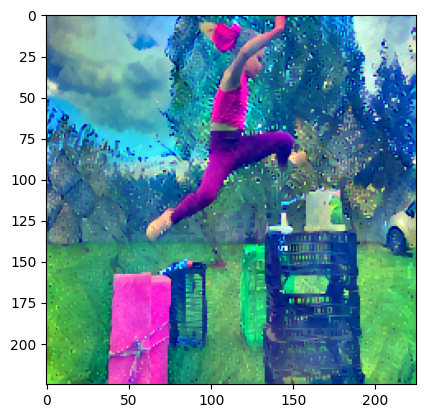

In [57]:
# 255*processed_images[-1]
# plt.imshow(image_utils.channel_last(deprocess(processed_images[-1])))
plt.imshow(image_utils.channel_last((processed_images[-1])))

In [22]:
processed_images

[array([[[0.        , 1.        , 0.17835632, ..., 0.        ,
          0.        , 0.00133559],
         [0.        , 0.        , 0.55535626, ..., 1.        ,
          0.        , 1.        ],
         [0.        , 1.        , 0.        , ..., 1.        ,
          0.        , 1.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          1.        , 0.        ],
         [1.        , 0.2283859 , 1.        , ..., 0.486527  ,
          0.        , 1.        ],
         [0.77532786, 0.66093534, 0.86877376, ..., 0.        ,
          0.        , 1.        ]],
 
        [[1.        , 0.        , 1.        , ..., 0.        ,
          0.        , 0.        ],
         [1.        , 0.        , 1.        , ..., 0.        ,
          1.        , 1.        ],
         [0.69071746, 0.        , 0.60816646, ..., 0.        ,
          1.        , 0.        ],
         ...,
         [0.        , 1.        , 0.        , ..., 1.        ,
          0.        , 0.

In [23]:
def get_loss(ref_content, ref_style, image_content, image_style, content_weight=0, style_weight=1):
    content_loss = torch.nn.functional.mse_loss(ref_content, image_content)
    style_loss = 0
    for gram_gt, gram_hat in zip(ref_style, image_style):
        style_loss += torch.nn.MSELoss(reduction='sum')(gram_gt, gram_hat)
    style_loss /= len(ref_style)
    print(content_loss, style_loss)
    loss = content_weight * content_loss + style_weight * style_loss
    return loss